In [1]:
import os
os.system('pip3 install -r requirements.txt')

0

Importamos las librerias

In [2]:
# Importamos las librerias necesarias
import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow import keras
import matplotlib.dates as mdates


Elegimos el stock que queramos
 

In [3]:
STOCK_LIST = [
    'AAPL'
]

Pillamos la fecha de hoy

as

In [4]:
# Download historical data for SPY from Yahoo Finance
spy = yf.download('AAPL', start='1000-01-01', end='2023-01-01')
print(spy)

# Split data into training (2010-2020) and validation (2020-2023) sets
training_data = spy['Adj Close']['2010-01-01':'2020-12-31']
validation_data = spy['Adj Close']['2021-01-01':'2023-01-01']

# Use 'Adj Close' prices as the stock price for training
training_set = training_data.values.reshape(-1, 1)
validation_set = validation_data.values.reshape(-1, 1)

[*********************100%%**********************]  1 of 1 completed
                  Open        High         Low       Close   Adj Close  \
Date                                                                     
1980-12-12    0.128348    0.128906    0.128348    0.128348    0.099319   
1980-12-15    0.122210    0.122210    0.121652    0.121652    0.094137   
1980-12-16    0.113281    0.113281    0.112723    0.112723    0.087228   
1980-12-17    0.115513    0.116071    0.115513    0.115513    0.089387   
1980-12-18    0.118862    0.119420    0.118862    0.118862    0.091978   
...                ...         ...         ...         ...         ...   
2022-12-23  130.919998  132.419998  129.639999  131.860001  131.127060   
2022-12-27  131.380005  131.410004  128.720001  130.029999  129.307251   
2022-12-28  129.669998  131.029999  125.870003  126.040001  125.339409   
2022-12-29  127.989998  130.479996  127.730003  129.610001  128.889587   
2022-12-30  128.410004  129.949997  127.430

In [5]:
# Feature scaling using MinMaxScaler
sc = MinMaxScaler(feature_range=(0, 1))
training_set_scaled = sc.fit_transform(training_set)
validation_set_scaled = sc.transform(validation_set)

In [6]:
# Creating input sequences for training
def create_sequences(data, seq_length=60):
    X = []
    y = []
    for i in range(seq_length, len(data)):
        X.append(data[i-seq_length:i, 0])
        y.append(data[i, 0])
    return np.array(X), np.array(y)

X_train, y_train = create_sequences(training_set_scaled)
X_validation, y_validation = create_sequences(validation_set_scaled)

# Reshape inputs for LSTM model
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_validation = np.reshape(X_validation, (X_validation.shape[0], X_validation.shape[1], 1))

In [7]:
# Building the LSTM Model
model = keras.Sequential()
model.add(keras.layers.LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], 1)))
model.add(keras.layers.Dropout(0.2))
model.add(keras.layers.LSTM(units=50, return_sequences=True))
model.add(keras.layers.Dropout(0.2))
model.add(keras.layers.LSTM(units=50, return_sequences=True))
model.add(keras.layers.Dropout(0.2))
model.add(keras.layers.LSTM(units=50))
model.add(keras.layers.Dropout(0.2))
model.add(keras.layers.Dense(units=1))

In [8]:
# Compiling the LSTM Model
model.compile(optimizer='adam', loss='mean_squared_error')

# Training the Model and store history
history = model.fit(X_train, y_train, epochs=100, batch_size=2048, validation_data=(X_validation, y_validation))


Epoch 1/100

2/2 [==============================] - 11s 2s/step - loss: 0.0726 - val_loss: 0.7596
Epoch 2/100
2/2 [==============================] - 2s 647ms/step - loss: 0.0351 - val_loss: 0.2290
Epoch 3/100
2/2 [==============================] - 1s 547ms/step - loss: 0.0123 - val_loss: 0.0142
Epoch 4/100
2/2 [==============================] - 1s 536ms/step - loss: 0.0192 - val_loss: 0.0731
Epoch 5/100
2/2 [==============================] - 1s 533ms/step - loss: 0.0074 - val_loss: 0.1803
Epoch 6/100
2/2 [==============================] - 1s 564ms/step - loss: 0.0089 - val_loss: 0.1740
Epoch 7/100
2/2 [==============================] - 1s 567ms/step - loss: 0.0086 - val_loss: 0.0643
Epoch 8/100
2/2 [==============================] - 1s 521ms/step - loss: 0.0038 - val_loss: 0.0079
Epoch 9/100
2/2 [==============================] - 1s 691ms/step - loss: 0.0025 - val_loss: 0.0591
Epoch 10/100
2/2 [==============================] - 2s 605ms/step - loss: 0.0045 - val_loss: 0.0155
Epoch 11/

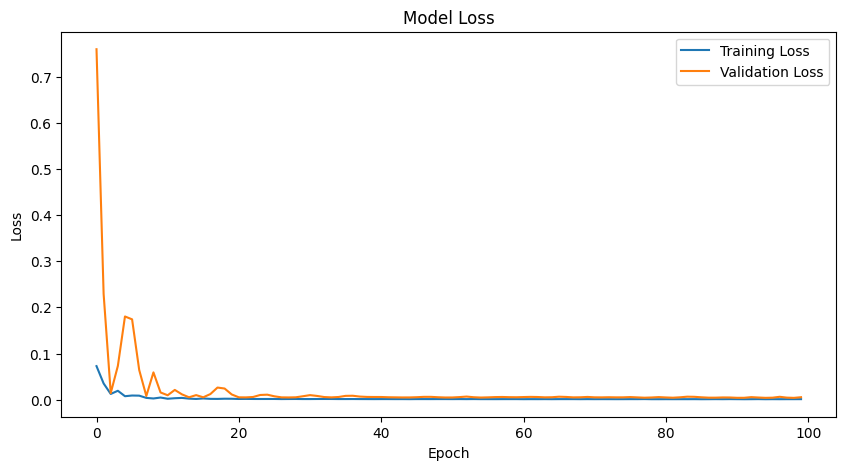

In [9]:
# Plot loss and accuracy during training
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [10]:
# Download test data for SPY from Yahoo Finance
spy_test = yf.download('AAPL', start='2023-01-01', end='2023-07-31')

# Use 'Adj Close' prices as the test data
real_stock_price = spy_test['Adj Close'].values.reshape(-1, 1)

[*********************100%%**********************]  1 of 1 completed


In [11]:
# Preparing Test Data
dataset_total = pd.concat((spy['Adj Close'], spy_test['Adj Close']), axis=0)
inputs = dataset_total[len(dataset_total) - len(spy_test) - 60:].values
inputs = inputs.reshape(-1, 1)
inputs = sc.transform(inputs)
X_test = []
for i in range(60, len(inputs)):
    X_test.append(inputs[i-60:i, 0])
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

In [12]:
# Making Predictions
predicted_stock_price = model.predict(X_test)
predicted_stock_price = sc.inverse_transform(predicted_stock_price)

5/5 [==============================] - 1s 22ms/step


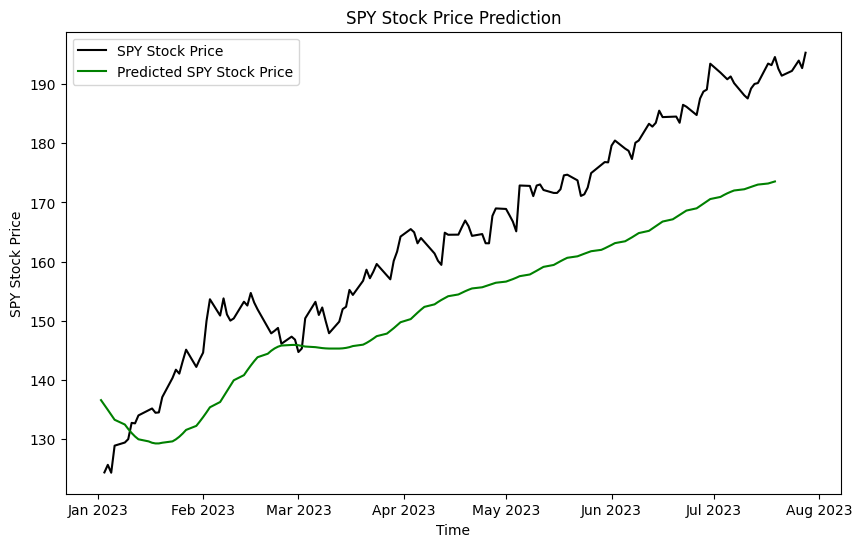

In [13]:
# Prepare dates for the predicted stock prices
date_range = pd.date_range(start='2023-01-01', periods=len(predicted_stock_price), freq='B')  # 'B' for business day frequency

# Visualizing Results with Month and Year on X-axis
plt.figure(figsize=(10, 6))
plt.plot(spy_test.index, real_stock_price, color='black', label='SPY Stock Price')
plt.plot(date_range, predicted_stock_price, color='green', label='Predicted SPY Stock Price')
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=1))  # Show tick marks for every 3 months
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))  # Format x-axis labels as 'Jan 2023', 'Feb 2023', etc.
plt.title('SPY Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('SPY Stock Price')
plt.legend()
plt.show()